# Importing libraries

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()  

use_gpu = torch.cuda.is_available()
if use_gpu:
    print("Using CUDA")

Using CUDA


# Utils

In [ ]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    # plt.figure(figsize=(10, 10))
    plt.axis('off')
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def show_databatch(inputs, classes):
    out = torchvision.utils.make_grid(inputs)
    imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def visualize_model(vgg, num_images=6):
    was_training = vgg.training
    
    # Set model for evaluation
    vgg.train(False)
    vgg.eval() 
    
    images_so_far = 0

    for i, data in enumerate(dataloaders[TEST]):
        inputs, labels = data
        size = inputs.size()[0]
        
        with torch.no_grad():
          if use_gpu:
              inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
          else:
              inputs, labels = Variable(inputs), Variable(labels)
        
        outputs = vgg(inputs)
        
        _, preds = torch.max(outputs.data, 1)
        predicted_labels = [preds[j] for j in range(inputs.size()[0])]
        
        print("Ground truth:")
        show_databatch(inputs.data.cpu(), labels.data.cpu())
        print("Prediction:")
        show_databatch(inputs.data.cpu(), predicted_labels)
        
        del inputs, labels, outputs, preds, predicted_labels
        torch.cuda.empty_cache()
        
        images_so_far += size
        if images_so_far >= num_images:
            break
        
    vgg.train(mode=was_training) # Revert model back to original training state

In [ ]:
def eval_model(vgg, criterion):
    since = time.time()
    avg_loss = 0
    avg_acc = 0
    loss_test = 0
    acc_test = 0
    
    test_batches = len(dataloaders[TEST])
    print("Evaluating model")
    print('-' * 10)
    
    for i, data in enumerate(dataloaders[TEST]):
        if i % 100 == 0:
            print("\rTest batch {}/{}".format(i, test_batches), end='', flush=True)

        vgg.train(False)
        vgg.eval()
        inputs, labels = data

        with torch.no_grad():
          if use_gpu:
              inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
          else:
              inputs, labels = Variable(inputs), Variable(labels)

        outputs = vgg(inputs)

        _, preds = torch.max(outputs.data, 1)
        loss = criterion(outputs, labels)

        loss_test += loss.item()
        acc_test += torch.sum(preds == labels.data)

        del inputs, labels, outputs, preds
        torch.cuda.empty_cache()
        
    avg_loss = loss_test / dataset_sizes[TEST]
    avg_acc = acc_test / dataset_sizes[TEST]
    
    elapsed_time = time.time() - since
    print()
    print("Evaluation completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Avg loss (test): {:.4f}".format(avg_loss))
    print("Avg acc (test): {:.4f}".format(avg_acc))
    print('-' * 10)

In [ ]:
def train_model(vgg, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()
    best_model_wts = copy.deepcopy(vgg.state_dict())
    best_acc = 0.0
    
    avg_loss = 0
    avg_acc = 0
    avg_loss_val = 0
    avg_acc_val = 0
    
    train_batches = len(dataloaders[TRAIN])
    val_batches = len(dataloaders[TEST])  # VAL -> TEST
    
    for epoch in range(num_epochs):
        print("Epoch {}/{}".format(epoch, num_epochs))
        print('-' * 10)
        
        loss_train = 0
        loss_val = 0
        acc_train = 0
        acc_val = 0
        
        vgg.train(True)
        
        for i, data in enumerate(dataloaders[TRAIN]):
            if i % 100 == 0:
                print("\rTraining batch {}/{}".format(i, train_batches / 2), end='', flush=True)
                
            # Use half training dataset
            if i >= train_batches / 2:
                break
                
            inputs, labels = data
            
            if use_gpu:
                inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
            else:
                inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss.backward()
            optimizer.step()
            
            loss_train += loss.item()
            acc_train += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        print()
        # * 2 as we only used half of the dataset
        avg_loss = loss_train * 2 / dataset_sizes[TRAIN]
        avg_acc = acc_train * 2 / dataset_sizes[TRAIN]
        
        vgg.train(False)
        vgg.eval()
            
        for i, data in enumerate(dataloaders[TEST]):  # VAL -> TEST
            if i % 100 == 0:
                print("\rValidation batch {}/{}".format(i, val_batches), end='', flush=True)
                
            inputs, labels = data
            
            with torch.no_grad():
              if use_gpu:
                  inputs, labels = Variable(inputs.cuda()), Variable(labels.cuda())
              else:
                  inputs, labels = Variable(inputs), Variable(labels)
            
            optimizer.zero_grad()
            
            outputs = vgg(inputs)
            
            _, preds = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            
            loss_val += loss.item()
            acc_val += torch.sum(preds == labels.data)
            
            del inputs, labels, outputs, preds
            torch.cuda.empty_cache()
        
        avg_loss_val = loss_val / dataset_sizes[TEST]  # VAL -> TEST
        avg_acc_val = acc_val / dataset_sizes[TEST]  # VAL -> TEST
        
        print()
        print("Epoch {} result: ".format(epoch))
        print("Avg loss (train): {:.4f}".format(avg_loss))
        print("Avg acc (train): {:.4f}".format(avg_acc))
        print("Avg loss (val): {:.4f}".format(avg_loss_val))
        print("Avg acc (val): {:.4f}".format(avg_acc_val))
        print('-' * 10)
        print()
        
        if avg_acc_val > best_acc:
            best_acc = avg_acc_val
            best_model_wts = copy.deepcopy(vgg.state_dict())
        
    elapsed_time = time.time() - since
    print()
    print("Training completed in {:.0f}m {:.0f}s".format(elapsed_time // 60, elapsed_time % 60))
    print("Best acc: {:.4f}".format(best_acc))
    
    vgg.load_state_dict(best_model_wts)
    return vgg

# Connect to Google Drive (if needed)

In [ ]:
# Подключить к google colab содержимое вашего google диск
from google.colab import drive
# This will prompt for authorization.
drive.mount('/content/drive')

Mounted at /content/drive


# Download data

In [ ]:
%%time
!tar -xzvf "/content/drive/MyDrive/Master/MW/datasets/NSL-KDD/images/NSL_KDD_image_train.tar.gz"

Выходные данные были обрезаны до нескольких последних строк (5000).
content/NSL_KDD_image_train/normal/81923.jpg
content/NSL_KDD_image_train/normal/122453.jpg
content/NSL_KDD_image_train/normal/83962.jpg
content/NSL_KDD_image_train/normal/54609.jpg
content/NSL_KDD_image_train/normal/49944.jpg
content/NSL_KDD_image_train/normal/87053.jpg
content/NSL_KDD_image_train/normal/8004.jpg
content/NSL_KDD_image_train/normal/105.jpg
content/NSL_KDD_image_train/normal/100667.jpg
content/NSL_KDD_image_train/normal/99119.jpg
content/NSL_KDD_image_train/normal/103539.jpg
content/NSL_KDD_image_train/normal/116458.jpg
content/NSL_KDD_image_train/normal/79508.jpg
content/NSL_KDD_image_train/normal/70123.jpg
content/NSL_KDD_image_train/normal/82329.jpg
content/NSL_KDD_image_train/normal/71792.jpg
content/NSL_KDD_image_train/normal/17658.jpg
content/NSL_KDD_image_train/normal/22060.jpg
content/NSL_KDD_image_train/normal/14407.jpg
content/NSL_KDD_image_train/normal/34152.jpg
content/NSL_KDD_image_train/nor

In [ ]:
%%time
!tar -xzvf "/content/drive/MyDrive/Master/MW/datasets/NSL-KDD/images/NSL_KDD_image_test.tar.gz"

Выходные данные были обрезаны до нескольких последних строк (5000).
content/NSL_KDD_image_test/normal/8577.jpg
content/NSL_KDD_image_test/normal/17661.jpg
content/NSL_KDD_image_test/normal/14437.jpg
content/NSL_KDD_image_test/normal/16644.jpg
content/NSL_KDD_image_test/normal/699.jpg
content/NSL_KDD_image_test/normal/2664.jpg
content/NSL_KDD_image_test/normal/17191.jpg
content/NSL_KDD_image_test/normal/14659.jpg
content/NSL_KDD_image_test/normal/5923.jpg
content/NSL_KDD_image_test/normal/17362.jpg
content/NSL_KDD_image_test/normal/14129.jpg
content/NSL_KDD_image_test/normal/673.jpg
content/NSL_KDD_image_test/normal/438.jpg
content/NSL_KDD_image_test/normal/9136.jpg
content/NSL_KDD_image_test/normal/5116.jpg
content/NSL_KDD_image_test/normal/1472.jpg
content/NSL_KDD_image_test/normal/21780.jpg
content/NSL_KDD_image_test/normal/13169.jpg
content/NSL_KDD_image_test/normal/18458.jpg
content/NSL_KDD_image_test/normal/22479.jpg
content/NSL_KDD_image_test/normal/6586.jpg
content/NSL_KDD_image

# Define dataloaders

In [ ]:
data_dir = 'content'
TRAIN = 'NSL_KDD_image_train'
TEST = 'NSL_KDD_image_test'

# VGG-16 Takes 224x224 images as input, so we resize all of them
data_transforms = {
    TRAIN: transforms.Compose([
        transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]),
    TEST: transforms.Compose([
        transforms.Resize(224),
        # transforms.CenterCrop(224),
        transforms.ToTensor(),
    ])
}

image_datasets = {
    x: datasets.ImageFolder(
        os.path.join(data_dir, x), 
        transform=data_transforms[x]
    )
    for x in [TRAIN, TEST]
}

dataloaders = {
    x: torch.utils.data.DataLoader(
        image_datasets[x], batch_size=8,
        shuffle=True, num_workers=2
    )
    for x in [TRAIN, TEST]
}

dataset_sizes = {x: len(image_datasets[x]) for x in [TRAIN, TEST]}

for x in [TRAIN, TEST]:
    print("Loaded {} images under {}".format(dataset_sizes[x], x))
    
print("Classes: ")
class_names = image_datasets[TRAIN].classes
print(image_datasets[TRAIN].classes)

Loaded 125973 images under NSL_KDD_image_train
Loaded 22544 images under NSL_KDD_image_test
Classes: 
['attack', 'normal']


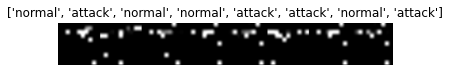

In [ ]:
# Get a batch of training data
inputs, classes = next(iter(dataloaders[TRAIN]))
show_databatch(inputs, classes)

# Create model

In [ ]:
!unzip "/content/drive/MyDrive/Master/MW/models/vgg16_bn.pth.zip"

Archive:  /content/drive/MyDrive/Master/MW/models/vgg16_bn.pth.zip
  inflating: vgg16_bn.pth            


In [ ]:
# Load the pretrained model from pytorch
vgg16 = models.vgg16_bn()
vgg16.load_state_dict(torch.load("vgg16_bn.pth"))
print(vgg16.classifier[6].out_features) # 1000 


# Freeze training for all layers
for param in vgg16.features.parameters():
    param.require_grad = False

# Newly created modules have require_grad=True by default
num_features = vgg16.classifier[6].in_features
features = list(vgg16.classifier.children())[:-1] # Remove last layer
features.extend([nn.Linear(num_features, len(class_names))]) # Add our layer with 2 outputs
vgg16.classifier = nn.Sequential(*features) # Replace the model classifier
print(vgg16)

1000
VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128

In [ ]:
# If you want to train the model for more than 2 epochs, set this to True after the first run
# resume_training = False

# if resume_training:
#     print("Loading pretrained model..")
#     vgg16.load_state_dict(torch.load('../input/vgg16-transfer-learning-pytorch/VGG16_v2-OCT_Retina.pt'))
#     print("Loaded!")

In [ ]:
if use_gpu:
    vgg16.cuda() #.cuda() will move everything to the GPU side
    
criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(vgg16.parameters(), lr=0.001, momentum=0.9)
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
%%time
print("Test before training")
eval_model(vgg16, criterion)

Test before training
Evaluating model
----------
Test batch 2800/2818
Evaluation completed in 9m 37s
Avg loss (test): 0.0870
Avg acc (test): 0.5491
----------
CPU times: user 7min 31s, sys: 2min 1s, total: 9min 32s
Wall time: 9min 36s


Ground truth:


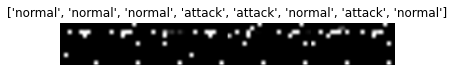

Prediction:


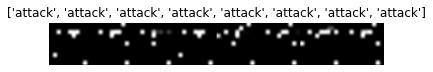

In [ ]:
visualize_model(vgg16) #test before training

# Model training

In [ ]:
vgg16 = train_model(vgg16, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=2)
torch.save(vgg16.state_dict(), 'VGG16_NSL_KDD.pt')

Epoch 0/2
----------
Training batch 7800/7873.5
Validation batch 2800/2818
Epoch 0 result: 
Avg loss (train): 0.0042
Avg acc (train): 0.9887
Avg loss (val): 0.1934
Avg acc (val): 0.7584
----------

Epoch 1/2
----------
Training batch 7800/7873.5
Validation batch 2800/2818
Epoch 1 result: 
Avg loss (train): 0.0020
Avg acc (train): 0.9949
Avg loss (val): 0.1542
Avg acc (val): 0.7824
----------


Training completed in 153m 15s
Best acc: 0.7824


# Evaluate

In [ ]:
eval_model(vgg16, criterion)

Evaluating model
----------
Test batch 2800/2818
Evaluation completed in 9m 37s
Avg loss (test): 0.1542
Avg acc (test): 0.7824
----------


Ground truth:


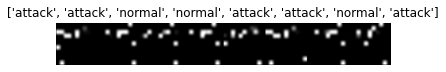

Prediction:


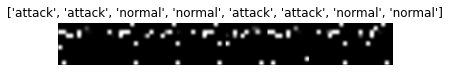

Ground truth:


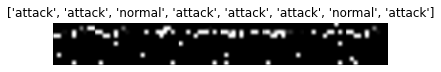

Prediction:


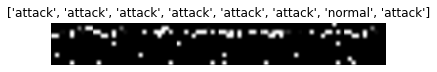

Ground truth:


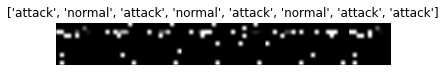

Prediction:


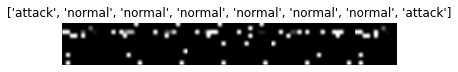

Ground truth:


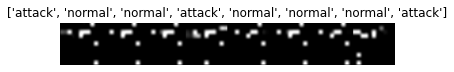

Prediction:


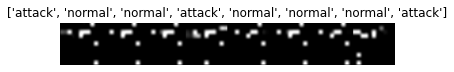

In [ ]:
visualize_model(vgg16, num_images=32)